# Digit classification model

Starting off with imports and ignoring warnings (to make things a bit tidier)

In [1]:
# from https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import keras
from keras.datasets import mnist
from keras import Sequential
from keras import layers
import matplotlib.pyplot as plt

Using TensorFlow backend.


Make sure my GPU is found, so the training can be done on my graphics card.

(this notebook should still work without a compatible graphics card set up, though)

In [2]:
# from https://www.tensorflow.org/guide/gpu
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### Loading the MNIST data set
Keras comes packed with some commonly used data sets, including the MNIST handwritten digit database.

This makes it very easy to get started.

In [3]:
# from https://keras.io/datasets/#mnist-database-of-handwritten-digits
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = mnist.load_data()

The next step is to convert the data set values into a form that fits our model.

This includes converting the labels into a binary class matrix, and reshaping the digit pixel values.

In [4]:
# from https://keras.io/getting-started/sequential-model-guide/
y_train = keras.utils.to_categorical(y_train_raw, num_classes=10, dtype="uint8")
y_test = keras.utils.to_categorical(y_test_raw, num_classes=10, dtype="uint8")

x_train = x_train_raw.reshape(60000,28,28,1)
x_test = x_test_raw.reshape(10000,28,28,1)

Here is how a single digit can be rendered on a graph using MatPlotLib.

Note that the pixel values are inverted, because the MNIST data set is white on a black background, while typically you would expect it to be the other way around.

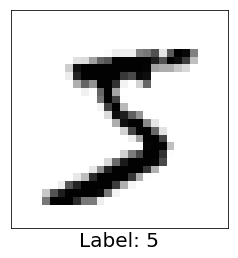

In [5]:
%matplotlib inline

def plot_digit(img_vals, label=None):
    # disable ticks/labels
    # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.tick_params.html
    plt.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)
    plt.imshow([255 - i for i in img_vals], cmap='gray')
    if label is not None:
        # add label below the image
        plt.rcParams.update({'font.size': 20})
        plt.xlabel("Label: {}".format(label), fontsize="medium")
        plt.rcParams.update({'font.size': 15})
    plt.show()

plot_digit(x_train_raw[0], y_train_raw[0])

Here is where the model gets built. I decided to use a convolutional neural network for my model, because they perform very well for image classification problems.

I watched [this](https://youtu.be/py5byOOHZM8) video by Computerphile to learn how CNNs work.

The basic idea is that at each convolutional layer (Conv2D), a [kernel](https://en.wikipedia.org/wiki/Kernel_(image_processing)) is passed over the image, extracting many different features (eg. edges). Since I use two convolutional layers, a kernal is passed again over those features to produce another, smaller, set of features. During backpropagation, the neural network can figure out how the features relate to the digits 0-9, and produce a prediction.

In [6]:
# decided on what layers to use, in what order, and which parameters, from a few different sources:
# https://keras.io/layers/convolutional/
# https://keras.io/examples/mnist_cnn/
# https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5
# https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

# https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363
# https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

model = Sequential()

# pull out big features in the layer (large kernel)
model.add(layers.Conv2D(32, kernel_size=5, activation="relu", input_shape=(28,28,1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))

# pull out smaller features from these big features (small kernel)
model.add(layers.Conv2D(32, kernel_size=3, activation="relu"))
model.add(layers.Conv2D(64, kernel_size=3, activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))

# finally, a simple dense layer of neurons
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

This trains the model.

**Epoch:** One complete pass over the training set. 18 epochs = 18 passes over the training data.

**Batch size:** Number of digits to train on the network in one go.

In [7]:
model.fit(x_train, y_train, epochs=18, batch_size=500)

Epoch 1/18
60000/60000 [==============================] - 3s 54us/step - loss: 2.0172 - accuracy: 0.6911
Epoch 2/18
60000/60000 [==============================] - 2s 36us/step - loss: 0.2416 - accuracy: 0.9245
Epoch 3/18
60000/60000 [==============================] - 2s 37us/step - loss: 0.1618 - accuracy: 0.9505
Epoch 4/18
60000/60000 [==============================] - 2s 36us/step - loss: 0.1261 - accuracy: 0.9604
Epoch 5/18
60000/60000 [==============================] - 2s 36us/step - loss: 0.1023 - accuracy: 0.9681
Epoch 6/18
60000/60000 [==============================] - 2s 36us/step - loss: 0.0884 - accuracy: 0.9721
Epoch 7/18
60000/60000 [==============================] - 2s 36us/step - loss: 0.0788 - accuracy: 0.9760
Epoch 8/18
60000/60000 [==============================] - 2s 35us/step - loss: 0.0691 - accuracy: 0.9793
Epoch 9/18
60000/60000 [==============================] - 2s 35us/step - loss: 0.0631 - accuracy: 0.9799
Epoch 10/18
60000/60000 [==============================

Evaluate the model on the test set.

(60,000 digits are for training, and the remaining 10,000 are for testing)

In [8]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 93us/step


[0.01917938077029394, 0.9933000206947327]

As a demonstration of the model, this code creates a bar chart showing the frequency of incorrect predictions produced by the model for each digit.

<Container object of 10 artists>

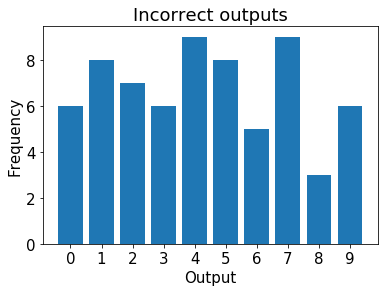

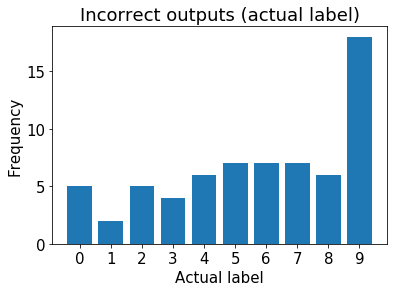

In [9]:
prediction_classes = model.predict_classes(x_test)

# initialize arrays
nums = np.arange(0, 10)
wrong_out_dist = np.zeros((10,))
wrong_out_label_dist = np.zeros((10,))

# compare predictions to actual labels
for i in range(len(prediction_classes)):
    if prediction_classes[i] != y_test_raw[i]:
        wrong_out_dist[prediction_classes[i]] += 1
        wrong_out_label_dist[y_test_raw[i]] += 1

# https://stackoverflow.com/questions/33203645/how-to-plot-a-histogram-using-matplotlib-in-python-with-a-list-of-data
# https://www.programcreek.com/python/example/56587/matplotlib.pyplot.title
plt.title("Incorrect outputs")
plt.xlabel("Output")
plt.ylabel("Frequency")
plt.bar(nums, wrong_out_dist, tick_label=nums)

plt.figure()
plt.title("Incorrect outputs (actual label)")
plt.xlabel("Actual label")
plt.ylabel("Frequency")
plt.bar(nums, wrong_out_label_dist, tick_label=nums)

As another demonstration, this code produces the top three digits that the model had trouble classifying.

(which should be the three most poorly drawn digits)

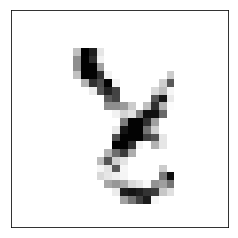

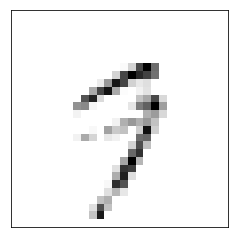

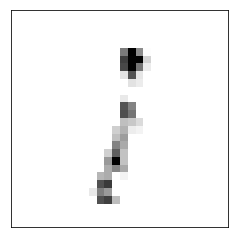

In [10]:
# get predictions for each digit in the test set
# (this differs from predict_classes, as this returns a probability distribution for each digit)
predictions = model.predict(x_test)
# get the highest prediction value for each digit (0-1 because of softmax)
confidence = [max(p) for p in predictions]
# get indexes of sorted confidence values (smallest to largest)
# a small max value from a probility distribution suggests uncertainty
confidence_sorted = np.argsort(confidence)

# plot those three digits
for i in range(3):
    plot_digit(x_test_raw[confidence_sorted[i]])

May as well train on the test data now too, with less epochs because it's a smaller set of data (10,000 instead of 60,000 images).

In [11]:
model.fit(x_test, y_test, epochs=3, batch_size=250)

Epoch 1/3
10000/10000 [==============================] - 1s 56us/step - loss: 0.0523 - accuracy: 0.9850
Epoch 2/3
10000/10000 [==============================] - 0s 47us/step - loss: 0.0399 - accuracy: 0.9877
Epoch 3/3
10000/10000 [==============================] - 0s 46us/step - loss: 0.0410 - accuracy: 0.9866


Finally, save the model to disk, to be later read back in on the Flask server.

In [12]:
# from https://machinelearningmastery.com/save-load-keras-deep-learning-models/
model.save("./flask/model.h5")